In [1]:
import napari
import glob
import os
from tifffile import imread
import numpy as np
import pandas as pd

from tifffile import imwrite

from skimage.util import img_as_ubyte
from PIL import Image, ImageDraw, ImageFont
from skimage import draw

from matplotlib import pyplot as plt
path = '/run/media/loaloa/lbb_ssd/primitives/'

In [15]:
with napari.gui_qt():
    viewer = napari.Viewer()

# Prim 1.1, 1.2 need to be redone with diff_sumratio metric
# Everything except Prim06 needs the canvas saved as a png

In [3]:
all_files = pd.read_csv(f'{path}/processed2/file_index.csv', index_col=(0,1,2,3))
primitives = all_files.index.unique(0)
print(primitives)
divs = all_files.index.unique(1)
print(divs)
print()

prim = primitives[4]
prim = 'Prim06'   # for getting all 6.1.1, 6.1.2 ...
div = divs[1]
lbl = f'{prim}_{div}'
dest_dir = f'{path}/processed2/results/{lbl}_masks/'

print('Processing now: ', lbl)
correct_prim = all_files.index.get_level_values(level=0).str.contains(prim)
correct_div = all_files.index.get_level_values(level=1).str.contains(div)

Index(['Prim01.1', 'Prim01.2', 'Prim02', 'Prim03.1', 'Prim03.2', 'Prim04',
       'Prim05', 'Prim06.1.1', 'Prim06.1.2', 'Prim06.2.3', 'Prim06.2.4',
       'Prim06.3.5', 'Prim06.3.6', 'Prim06.4.7', 'Prim06.4.8'],
      dtype='object')
Index(['DIV14', 'DIV7'], dtype='object')

Processing now:  Prim06_DIV7


In [44]:
files = all_files[correct_prim&correct_div].values.flatten()
print(files)

png_images = [np.asarray(Image.open(f)) for f in files]
npy_images = [np.load(f.replace('.png', '.npy')) for f in files]

to_yshape = np.max([i.shape[0] for i in npy_images])
png_images = [np.pad(im, ((to_yshape-im.shape[0],0), (0,0), (0,0)), mode='constant') for im in png_images]
npy_images = [np.pad(im, ((to_yshape-im.shape[0],0), (0,0), (0,0)), mode='constant') for im in npy_images]

png_prim_im = np.concatenate(png_images, 1)
npy_prim_im = np.concatenate(npy_images, 1)[...,:2].astype(float) /2**16

print(npy_prim_im.shape)

viewer.add_image(png_prim_im, name=prim+'_'+div)
imwrite(f'{dest_dir}/{lbl}_data.png', img_as_ubyte(png_prim_im))
# viewer.add_image(npy_prim_im, name='npy'+prim+div)

['/run/media/loaloa/lbb_ssd/primitives//processed2/exp14_DIV14_processed_Prim03.2_G002.png']
(6507, 2917, 2)


FileNotFoundError: [Errno 2] No such file or directory: '/run/media/loaloa/lbb_ssd/primitives/processed2/results/Prim03.2_DIV14_masks/Prim03.2_DIV14_data.png'

In [47]:
add_n_shape_layers = 8
for i in range(5, add_n_shape_layers+1):
    viewer.add_labels(np.zeros(png_prim_im.shape[:2], int), name=f'{lbl}_{i:0>2}_lbl')
    # break

In [51]:
layers = [np.load(f) for f in glob.glob(f'{path}/processed2/results/{lbl}_masks/*_mask.npy')]
[viewer.add_labels(dat, name=f'{lbl}_{i:0>2}_lbl') for i, dat in enumerate(layers)]
[print(d.shape) for d in layers]

(6507, 2917)
(6507, 2917)
(6507, 2917)
(6507, 2917)
(6507, 2917)
(6507, 2917)
(6507, 2917)
(6507, 2917)


[None, None, None, None, None, None, None, None]

In [54]:
os.makedirs(dest_dir, exist_ok=True)
layers = [l for l in viewer.layers if l.name.endswith('_lbl')]
print(len(layers))
[np.save(f'{dest_dir}/{l.name}_mask.npy', l.data) for l in layers]

all_masks = np.stack([l.data.copy() for l in layers], axis=-1).sum(-1)
u = np.unique(all_masks, return_counts=True)
u

8


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 array([18900391,     2667,     2811,     2937,     2446,     2528,
            2428,     2614,     2785,     2703,     2019,     2077,
            2096,     2897,     3015,     3032,     2815,     2847,
            3037,     2790,     2916,     2956,     2849,     3042,
            3061,     2006,     2012,     2069,     1497,     1493,
            1548,     1428,     1534,     1573]))

In [5]:
design_namemap = {
    'Prim01.1': {
        0: '2um, r1',
        1: '3.5um, r1',
        2: '3.5um, r1',
        3: '5.5um, r1',
        
        4: '2um, r2',
        5: '2.5um, r2',
        6: '3.5um, r2',
        7: '5.5um, r2',
        
        8:  '2um, r3',
        9:  '3.5um, r3',
        10: '3.5um, r3',
        11: '5.5um, r3',
        
        12: 'neg. control',
    },

    'Prim01.2': {

        0: 'r4',
        1: 'r3',
        2: 'r2',
        3: 'r1',
        # 4: 'r5',  <- 0
        5: 'r6',
    },


    'Prim04': {
        7: '10_spikes',
        6: '06_spikes',
        5: '04_spikes',
        4: '02_spikes',
        3: 'neg_control',
        2: '10_hills',
        1: '04_hilld',
        0: '02_hills',
    },

    'Prim05': {
        1: 'backward stomache',

        2: 'backward rescue loops',
        3: 'forward rescue loops',

        4: 'backward negative control',
        5: 'forward negative control',

        6: 'forward rescue loops angled',
        7: 'backward rescue loops angled',

        8: 'forward stomache',
    },

    'Prim06': {
        1: 'negative control',

        2: '3um opening',
        3: '5um opening',

        4: 'angled entry',
        5: '1.5um opening',

        6: 'inlay',
        7: 'tangential entry',

        8: '2x size',
    },
}

min_int_thr = .04
min_seg_area_size = 120

# Prim1.1
n_variants = 13
unit_size = 3
# Prim1.2
n_variants = 6
unit_size = 3
# # Prim2
n_variants = 32
unit_size = 2
# Prim3.2
n_variants = 11
unit_size = 3
# # Prim04
# n_variants = 8
# unit_size = 3
# # Prim05
# n_variants = 2
# unit_size = 9
# # Prim06
# n_variants = 16
# unit_size = 3

In [56]:
# Prim 01, 03, 04 

data = []
confirmation_canvas = np.zeros_like(png_prim_im, float)
confirmation_mask = np.zeros(png_prim_im.shape[:2], int)
for i in range(len(layers)):
    print('layer ', i, end='...   ')
    dat = layers[i].data
    
    for j in range(n_variants):
        for k in range(unit_size):
            mask_idx = j*unit_size +k +1
            mask = dat==mask_idx

            channel_region = npy_prim_im[mask]
            if mask.sum() > min_seg_area_size:
                median_int = np.median(channel_region, 0)
            else:
                median_int = [0, 0]

            confirmation_canvas[mask, 0] = median_int[0]
            confirmation_canvas[mask, 1] = median_int[1]

            if k == 0: 
                channel = 'inlet'
                confirmation_mask[mask] = 1
            elif k == 1:
                channel = 'straight'
                confirmation_mask[mask] = 2
            elif k == 2:
                channel = 'turn'
                confirmation_mask[mask] = 3

            
            idx = pd.MultiIndex.from_tuples(((j, i, channel, 'RFP'), (j, i, channel, 'GFP')), 
                                            name=('design','replicate', 'channel', 'color'))
            data.append(pd.Series(median_int, index=idx, name=(lbl)))

# viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
confirmation_canvas[confirmation_canvas<min_int_thr] = 0
viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
imwrite(f'{dest_dir}/segmentation_overview.png', img_as_ubyte(confirmation_canvas))

viewer.add_labels(confirmation_mask, blending='additive')

layer  0...   layer  1...   layer  2...   layer  3...   layer  4...   layer  5...   layer  6...   layer  7...   

<Labels layer 'confirmation_mask' at 0x7fede3bcceb0>

In [9]:
def draw_line(canvas, ystart_coo,xstart_coo, ystop_coo,xstop_coo, col=(.8,.8,.8)):
    confirmation_canvas[draw.line(ystart_coo, xstart_coo, ystop_coo, xstop_coo)] = col
    confirmation_canvas[draw.line(ystart_coo, xstart_coo+1, ystop_coo, xstop_coo+1)] = col
    confirmation_canvas[draw.line(ystart_coo, xstart_coo-1, ystop_coo, xstop_coo-1)] = col

In [15]:
# pre Prim 02 (get_distance)
confirmation_canvas = np.zeros_like(png_prim_im, float)

tot_length_mask = viewer.layers['dist'].data
y_coo_start = np.where(tot_length_mask==1)[0].max()
x_coo_start = np.where(tot_length_mask==1)[1].mean().astype(int)
y_coo_stop = np.where(tot_length_mask==2)[0].max()
x_coo_stop = np.where(tot_length_mask==2)[1].mean().astype(int)
draw_line(confirmation_canvas, y_coo_start, x_coo_start, y_coo_stop, x_coo_stop)
tot_length = np.sqrt((y_coo_start-y_coo_stop)**2 + (x_coo_start-x_coo_stop)**2)
print(tot_length)

# viewer.add_image(confirmation_canvas, blending='additive')

1564.0012787718558


In [17]:
# Prim 02

data = []
for i in range(len(layers)):
    print('layer ', i, end='...   ')
    dat = layers[i].data
    
    for j in range(n_variants):
        for k in range(unit_size):
            mask_idx = j*unit_size +k +1
            mask = dat==mask_idx
            if mask.sum() < min_seg_area_size:
                dist = np.nan
            
            else:
                y_coo = np.where(mask)[0].max()
                x_coo = np.where(mask)[1].mean().astype(int)
                if k == 0:
                    ystart_coo = y_coo.copy()
                    xstart_coo = x_coo.copy()
                elif k == 1:
                    dist = np.abs(ystart_coo - y_coo) /tot_length
                    draw_line(confirmation_canvas, ystart_coo,xstart_coo, y_coo,x_coo)
                
            if k == 1:
                idx = pd.MultiIndex.from_tuples(( (j, i), ), 
                                                name=('design','replicate'))
                data.append(pd.Series([dist], index=idx, name=(lbl)))
viewer.add_image(confirmation_canvas, blending='additive')
imwrite(f'{dest_dir}/segmentation_overview.png', img_as_ubyte(confirmation_canvas))


im02_DIV7, dtype: float64
design  replicate
5       1            0.503836
Name: Prim02_DIV7, dtype: float64
design  replicate
6       1            0.072251
Name: Prim02_DIV7, dtype: float64
design  replicate
7       1           NaN
Name: Prim02_DIV7, dtype: float64
design  replicate
8       1           NaN
Name: Prim02_DIV7, dtype: float64
design  replicate
9       1           NaN
Name: Prim02_DIV7, dtype: float64
design  replicate
10      1           NaN
Name: Prim02_DIV7, dtype: float64
design  replicate
11      1           NaN
Name: Prim02_DIV7, dtype: float64
design  replicate
12      1            0.191816
Name: Prim02_DIV7, dtype: float64
design  replicate
13      1           NaN
Name: Prim02_DIV7, dtype: float64
design  replicate
14      1           NaN
Name: Prim02_DIV7, dtype: float64
design  replicate
15      1            0.154092
Name: Prim02_DIV7, dtype: float64
design  replicate
16      1           NaN
Name: Prim02_DIV7, dtype: float64
design  replicate
17      1           

In [12]:
# Prim 05
# valid datapaints needs to have a cl
# 1 start green, 2-9 
# 10 start red, 11-18 


data = []
confirmation_canvas = np.zeros_like(png_prim_im, float)
for i in range(len(layers)):
    print('layer ', i, end='...   ')
    dat = layers[i].data
    
    dists, replicate_lbls, design_lbls = [], [], []
    for j in range(n_variants):
        for k in range(unit_size):
            mask_idx = j*unit_size +k +1
            mask = dat==mask_idx

            if mask.sum() < min_seg_area_size:
                dist = np.nan
            else:
                y_coo = np.where(mask)[0].max()
                x_coo = np.where(mask)[1].max().astype(int)
                # take care of start line segmentation
                if k == 0:
                    ystart_coo = y_coo.copy()
                    xstart_coo = x_coo.copy()
                    if j == 0:
                        GFP_ystart_coo = ystart_coo.copy()
                        GFP_xstart_coo = xstart_coo.copy()
                    elif j == 1:
                        well_dist = np.sqrt((GFP_ystart_coo-ystart_coo)**2 + (GFP_xstart_coo-xstart_coo)**2)
                        print('Well dist: ', well_dist)
                        draw_line(confirmation_canvas, GFP_ystart_coo,GFP_xstart_coo, ystart_coo,xstart_coo)
                    continue
                else:
                    dist = np.abs(ystart_coo - y_coo)
                    col = (.8,.1,.1) if j else (.1,.8,.1)
                    draw_line(confirmation_canvas, ystart_coo,x_coo, y_coo,x_coo, col)
                
            if k:
                dists.append(dist)
                design = k if j==0 else unit_size-k
                replicate = j +i*2
                
                design_lbls.append(design)
                replicate_lbls.append(replicate)
    
    idx = pd.MultiIndex.from_tuples([(d, r) for d,r in zip(design_lbls, replicate_lbls)], 
                                    names=('design','replicate'))
    print(pd.Series(dists, index=idx, name=(lbl)) /well_dist)
    data.append(pd.Series(dists, index=idx, name=(lbl)) /well_dist)

viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
imwrite(f'{dest_dir}/segmentation_overview.png', img_as_ubyte(confirmation_canvas))

layer  0...   Well dist:  1078.5147194174033
design  replicate
1       0            0.011126
2       0            0.372735
3       0            0.721362
4       0            0.746397
5       0            0.725071
6       0            0.997668
7       0            0.312467
8       0            0.993960
        1            0.070467
7       1            0.862297
6       1            0.831699
5       1            0.529432
4       1            0.983760
3       1            0.761232
2       1            0.980979
1       1                 NaN
Name: Prim05_DIV7, dtype: float64
layer  1...   Well dist:  1075.0041860383615
design  replicate
1       2            0.013953
2       2            0.973019
3       2            0.652090
4       2            0.743253
5       2            0.258604
6       2            0.047442
7       2            0.088372
8       2            1.000926
        3                 NaN
7       3                 NaN
6       3                 NaN
5       3                 NaN


In [15]:
# Prim 06

# label green side first, then red, then output
# Go from top to bottom, left to right
# 

data = []
confirmation_canvas = np.zeros_like(png_prim_im, float)
confirmation_mask = np.zeros(png_prim_im.shape[:2], int)
for i in range(len(layers)):
    print('layer ', i, end='...   ')
    dat = layers[i].data
    
    for j in range(n_variants):
        for k in range(unit_size):
            mask_idx = j*unit_size +k +1
            mask = dat==mask_idx

            channel_region = npy_prim_im[mask]
            if mask.sum() > min_seg_area_size:
                median_int = np.median(channel_region, 0)
            else:
                median_int = [0, 0]

            confirmation_canvas[mask, 0] = median_int[0]
            confirmation_canvas[mask, 1] = median_int[1]

            if k == 0:
                channel = 'GFP_in'
                confirmation_mask[mask] = 1
            elif k == 1:
                channel = 'RFP_in'
                confirmation_mask[mask] = 2
            elif k == 2:
                channel = 'outlet'
                confirmation_mask[mask] = 3

            
            idx = pd.MultiIndex.from_tuples(((i+1, j, channel, 'RFP'), (i+1, j, channel, 'GFP')), 
                                            name=('design','replicate', 'channel', 'color'))
            data.append(pd.Series(median_int, index=idx, name=(lbl)))
viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
confirmation_canvas[confirmation_canvas<min_int_thr] = 0
viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
imwrite(f'{dest_dir}/segmentation_overview.png', img_as_ubyte(confirmation_canvas))


viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
confirmation_canvas[confirmation_canvas<min_int_thr] = 0
viewer.add_image(confirmation_canvas, blending='additive', contrast_limits=(0,.05))
imwrite(f'{dest_dir}/segmentation_overview.png', img_as_ubyte(confirmation_canvas))

viewer.add_labels(confirmation_mask, blending='additive')

layer  0...   

KeyboardInterrupt: 

In [57]:
# Prim 01, 03,  04, 06
data = pd.concat(data, axis=0).to_frame()
data[data<min_int_thr] = 0
data.to_csv(f'{dest_dir}/{lbl}_intensities.csv')

# Prim 02, 05
# data = pd.concat(data, axis=0).to_frame()
# data.columns = [prim]
# data.sort_index().to_csv(f'{dest_dir}/{lbl}_metrics.csv')

data.sort_index()

Prim03.2_DIV14
design replicate channel  color                
0      0         inlet    GFP          0.138184
                          RFP          0.089111
                 straight GFP          0.062500
                          RFP          0.067017
                 turn     GFP          0.080566
...                                         ...
10     7         inlet    RFP          0.000000
                 straight GFP          0.000000
                          RFP          0.000000
                 turn     GFP          0.000000
                          RFP          0.000000

[528 rows x 1 columns]

In [58]:
# col = data.index.get_level_values(3)
# greens = data[col=='GFP']
# reds = data[col=='RFP']
# %matplotlib qt5
# plt.hist(reds, bins=150, alpha=.5, range=(0,.10))
# plt.hist(greens, bins=150, alpha=.5, range=(0,.10))


data.loc[1]

Prim03.2_DIV14
replicate channel  color                
0         inlet    RFP          0.040527
                   GFP          0.042236
          straight RFP          0.000000
                   GFP          0.000000
          turn     RFP          0.000000
                   GFP          0.042236
1         inlet    RFP          0.067749
                   GFP          0.081909
          straight RFP          0.045410
                   GFP          0.058838
          turn     RFP          0.079224
                   GFP          0.074463
2         inlet    RFP          0.040283
                   GFP          0.073975
          straight RFP          0.040039
                   GFP          0.074463
          turn     RFP          0.041870
                   GFP          0.153931
3         inlet    RFP          0.000000
                   GFP          0.000000
          straight RFP          0.000000
                   GFP          0.000000
          turn     RFP          0.000000
                   GFP          0.000000
4         inlet    RFP          0.066284
                   GFP          0.066772
          straight RFP          0.043701
                   GFP          0.000000
          turn     RFP          0.057861
                   GFP          0.102295
5         inlet    RFP          0.048584
                   GFP          0.047119
          straight RFP          0.045898
                   GFP          0.066406
          turn     RFP          0.045410
                   GFP          0.000000
6         inlet    RFP          0.000000
                   GFP          0.000000
          straight RFP          0.000000
                   GFP          0.000000
          turn     RFP          0.000000
                   GFP          0.000000
7         inlet    RFP          0.000000
                   GFP          0.000000
          straight RFP          0.000000
                   GFP          0.000000
          turn     RFP          0.000000
                   GFP          0.000000

In [11]:
# For Primitive 01, 03, 04, 06
def get_metric(which_metric, which_prim, dat):
    if which_prim.startswith('Prim01') or which_prim.startswith('Prim04') or which_prim.startswith('Prim03'):
        inlet = dat[slice(None),slice(None),'inlet']
        straight = dat[slice(None),slice(None),'straight']
        turn = dat[slice(None),slice(None),'turn']

        if which_metric == 'diff_ratio':
            m = (straight-turn) /inlet
            if (inlet == 0).all():
                m.loc[:] = np.nan
        
        elif which_metric == 'diff_sumratio':
            m = (straight-turn) / (straight+turn)
            if (inlet == 0).all():
                m.loc[:] = np.nan
    
        elif which_metric == 'diff_sumratio_intweighted':
            m = inlet *(straight-turn) / (straight+turn)
            if (inlet == 0).all():
                m.loc[:] = np.nan
    
        elif which_metric == 'diff':
            m = (straight-turn)

    elif which_prim.startswith('Prim06'):
        outlet = dat[slice(None),slice(None),'outlet']
        if dat.index.unique('color') == ['GFP']:
            inlet = dat[slice(None),slice(None),'GFP_in']
            turn = dat[slice(None),slice(None),'RFP_in']
        elif dat.index.unique('color') == ['RFP']:
            inlet = dat[slice(None),slice(None),'RFP_in']
            turn = dat[slice(None),slice(None),'GFP_in']

        if which_metric == 'diff_sumratio':
            m = (inlet-turn) / (inlet+turn)
            if (outlet == 0).all() or (inlet == 0).all():
                m.loc[:] = np.nan
        
        elif which_metric == 'diff_sumratio_intweighted':
            m = inlet * (inlet-turn) / (inlet+turn)
            if (outlet == 0).all() or (inlet == 0).all():
                m.loc[:] = np.nan



    return m
    # m.index = pd.MultiIndex.from_tuples([(*m.index[0], 'metric'),], names=m.index.names+['inlet'])
    # return m.swaplevel()
    


In [14]:
# For Primitive 01, 03, 04, 06

data = pd.read_csv(f'{dest_dir}/{lbl}_intensities.csv', index_col=(0,1,2,3))

which_metric = 'diff_sumratio_intweighted'
# which_metric = 'diff_sumratio'
# which_metric = 'diff_ratio'
# which_metric = 'diff'
all_metric = []
for datapoint in data.index.droplevel([2,3]).unique():

    col_metrics = []
    for color in data.index.unique('color'):
        if color == 'RFP' and prim == 'Prim03.2':
            continue
        col_dat = data.loc[(*datapoint, slice(None), color), lbl]
        col_metrics.append(get_metric(which_metric, prim, col_dat))
        
    datapoint_metric = pd.concat(col_metrics).mean()
    print()
    print()
    print(pd.concat(col_metrics))
    idx = pd.MultiIndex.from_tuples([datapoint], names=data.index.names[:2])
    all_metric.append(pd.Series([datapoint_metric], index=idx, name=which_metric))
    print(all_metric[-1])

all_metrics = pd.concat(all_metric).to_frame().sort_index()
all_metrics.to_csv(f'{dest_dir}/{lbl}_metrics.csv')
all_metrics

[design  replicate  color
1       0          RFP     NaN
Name: Prim06_DIV7, dtype: float64, design  replicate  color
1       0          GFP     NaN
Name: Prim06_DIV7, dtype: float64]

[design  replicate  color
1       1          RFP      0.079468
Name: Prim06_DIV7, dtype: float64, design  replicate  color
1       1          GFP      0.218476
Name: Prim06_DIV7, dtype: float64]

[design  replicate  color
1       2          RFP      0.020968
Name: Prim06_DIV7, dtype: float64, design  replicate  color
1       2          GFP     NaN
Name: Prim06_DIV7, dtype: float64]

[design  replicate  color
1       3          RFP      0.004752
Name: Prim06_DIV7, dtype: float64, design  replicate  color
1       3          GFP      0.276855
Name: Prim06_DIV7, dtype: float64]

[design  replicate  color
1       4          RFP      0.037754
Name: Prim06_DIV7, dtype: float64, design  replicate  color
1       4          GFP     NaN
Name: Prim06_DIV7, dtype: float64]

[design  replicate  color
1       5         

diff_sumratio_intweighted
design replicate                           
1      0                                NaN
       1                           0.148972
       2                           0.020968
       3                           0.140803
       4                           0.037754
...                                     ...
8      3                           0.292452
       4                                NaN
       5                                NaN
       6                                NaN
       7                                NaN

[64 rows x 1 columns]

In [56]:
# Prim01.1 special
# fiixng Prim01: design 1,2 and 9,10 are accidentlally the same 
# To avoid duplicate labels rename design 2 to 1, and 10 to 9, adjust replicate accordingly 
all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics_old.csv', index_col=(0,1))

design_namemap =  {
        0: '2um, r1',
        1: '3.5um, r1',
        # 2: '3.5um, r1', <- make 1, repl 8...15
        3: '5.5um, r1',
        
        4: '2um, r2',
        5: '2.5um, r2',
        6: '3.5um, r2',
        7: '5.5um, r2',
        
        8:  '2um, r3',
        9:  '3.5um, r3',
        # 10: '3.5um, r3',  <- make 9, repl 8...15
        11: '5.5um, r3',
        
        12: 'neg. control',
    }

design_2 = all_metrics.loc[[2], :]
all_metrics.drop(2, inplace=True)
design_2.index = pd.MultiIndex.from_tuples([(1, i+len(design_2)) for i in range(len(design_2))])
print(design_2)

design_10 = all_metrics.loc[[10], :]
all_metrics.drop(10, inplace=True)
design_10.index = pd.MultiIndex.from_tuples([(9, i+len(design_2)) for i in range(len(design_10))])
print(design_10)

all_metrics_fixed = pd.concat([all_metrics, design_2, design_10], ).sort_index()
all_metrics_fixed.to_csv(f'{dest_dir}/{lbl}_metrics.csv')

      diff_sumratio_intweighted
1 16                   0.075356
  17                        NaN
  18                        NaN
  19                        NaN
  20                        NaN
  21                   0.000125
  22                        NaN
  23                        NaN
  24                   0.003035
  25                   0.004179
  26                   0.003686
  27                   0.004526
  28                   0.060473
  29                   0.038333
  30                        NaN
  31                        NaN
      diff_sumratio_intweighted
9 16                        NaN
  17                        NaN
  18                  -0.000142
  19                        NaN
  20                        NaN
  21                   0.068222
  22                        NaN
  23                        NaN
  24                        NaN
  25                   0.005814
  26                   0.009039
  27                        NaN
  28                   0.039274
  29    

In [12]:
# Prim01.2 special
# fiixng Prim01.2: design 0,4 are accidentlally the same 
all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics_old.csv', index_col=(0,1))

design_namemap =  {
        0: '2um, r1',
        1: '3.5um, r1',
        # 2: '3.5um, r1', <- make 1, repl 8...15
        3: '5.5um, r1',
        
        4: '2um, r2',
        5: '2.5um, r2',
        6: '3.5um, r2',
        7: '5.5um, r2',
        
        8:  '2um, r3',
        9:  '3.5um, r3',
        # 10: '3.5um, r3',  <- make 9, repl 8...15
        11: '5.5um, r3',
        
        12: 'neg. control',
    }

design_4 = all_metrics.loc[[4], :]
all_metrics.drop(4, inplace=True)
design_4.index = pd.MultiIndex.from_tuples([(0, i+len(design_4)) for i in range(len(design_4))])
print(design_4)

# design_10 = all_metrics.loc[[10], :]
# all_metrics.drop(10, inplace=True)
# design_10.index = pd.MultiIndex.from_tuples([(9, i+len(design_2)) for i in range(len(design_10))])
# print(design_10)

all_metrics_fixed = pd.concat([all_metrics, design_4], ).sort_index()
all_metrics_fixed.to_csv(f'{dest_dir}/{lbl}_metrics.csv')
all_metrics_fixed

      diff_sumratio_intweighted
0 16                        NaN
  17                        NaN
  18                   0.025918
  19                        NaN
  20                        NaN
  21                   0.073619
  22                        NaN
  23                        NaN
  24                        NaN
  25                   0.012649
  26                   0.009293
  27                   0.003089
  28                   0.016897
  29                   0.003515
  30                   0.006872
  31                   0.023304


diff_sumratio_intweighted
design replicate                           
0      0                                NaN
       1                                NaN
       2                           0.221448
       3                                NaN
       4                           0.080764
...                                     ...
5      11                               NaN
       12                          0.002885
       13                          0.043298
       14                               NaN
       15                          0.001618

[96 rows x 1 columns]

In [7]:
# =========== PRIM 1.1 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)))


designs = all_metrics.index.unique('design')

xlbls = []
plt.title(lbl+' DESIGN')
for d in designs:
    design_metrics = all_metrics[d]
    xlbls.append(design_namemap[prim][d])
    median = design_metrics.mean()
    xlocs = [d]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(d, median, marker='_', s=500, color='k')
plt.gca().set_xticks(np.arange(len(designs)))
plt.gca().set_xticklabels(xlbls, rotation=45)

plt.figure()
plt.title(lbl+' RADIUS')
design_sets = ([0,1,2,3], [4,5,6,7], [8,9,10,11], [12])
for xloc, design_set in enumerate(design_sets):
    design_metrics = all_metrics[design_set]
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)

    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

plt.figure()
plt.title(lbl+' OPENING DIAMETER')
design_sets = ([0,4,8], [1,5,9], [2,6,10], [3,7,11], [12])
for xloc, design_set in enumerate(design_sets):
    design_metrics = all_metrics[design_set]
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)

    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')


                  diff_sumratio_intweighted
design replicate                           
0      0                           0.051839
1      0                           0.051636
2      0                           0.053467
3      0                           0.058838
4      0                           0.133027
...                                     ...
8      7                           0.050415
9      7                                NaN
10     7                                NaN
11     7                           0.061768
12     7                           0.034148

[104 rows x 1 columns]


NameError: name 'design_namemap' is not defined

                  diff_sumratio_intweighted
design replicate                           
0      0                                NaN
       1                                NaN
       2                           0.221448
       3                                NaN
       4                           0.080764
...                                     ...
5      11                               NaN
       12                          0.002885
       13                          0.043298
       14                               NaN
       15                          0.001618

[96 rows x 1 columns]
design  replicate
0       0                 NaN
        1                 NaN
        2            0.221448
        3                 NaN
        4            0.080764
                       ...   
5       11                NaN
        12           0.002885
        13           0.043298
        14                NaN
        15           0.001618
Name: diff_sumratio_intweighted, Length: 96, dtype: float

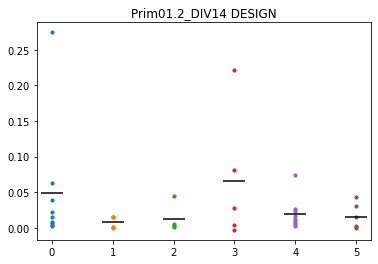

In [9]:

# =========== PRIM 1.2 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)))
print(all_metrics)

designs = all_metrics.index.unique('design')
designs = [3,2,1,0,4,5]

plt.title(lbl+' DESIGN')
for xloc, d in enumerate(designs):
    print(xloc, d)
    design_metrics = all_metrics[d]
    median = design_metrics.mean()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

design  replicate
0       0           -0.017450
        1            0.005325
        2           -0.041166
        3           -0.054321
        4           -0.226147
                       ...   
10      3                 NaN
        4                 NaN
        5                 NaN
        6                 NaN
        7                 NaN
Name: diff_sumratio_intweighted, Length: 88, dtype: float64
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10


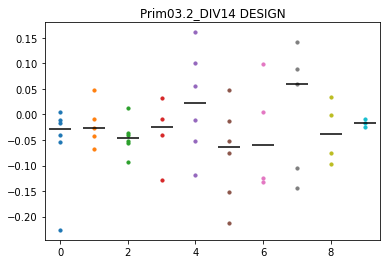

In [61]:

# =========== PRIM 2 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics)

designs = all_metrics.index.unique('design')

plt.title(lbl+' DESIGN')
for xloc, d in enumerate(designs):
    print(xloc, d)
    design_metrics = all_metrics[d]
    if design_metrics.notna().sum() < 3:
        continue
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

design  replicate
0       0           -0.253664
        1           -0.212646
        2                 NaN
        3           -0.083008
        4                 NaN
                       ...   
10      1                 NaN
        2                 NaN
        3           -0.033827
        4           -0.050130
        5                 NaN
Name: diff_sumratio_intweighted, Length: 66, dtype: float64
Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int64', name='design')


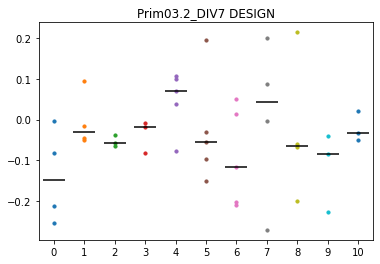

In [42]:
# =========== PRIM 04 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics)

designs = all_metrics.index.unique('design')
# designs = [3, 0,1,2,4,5,6,7]
print(designs)

plt.title(lbl+' DESIGN')
xlbls = []
for xloc, d in enumerate(designs):
    # xlbls.append(design_namemap[prim][d])
    # print(d, xloc, design_namemap[prim][d])
    
    design_metrics = all_metrics[d]
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

plt.gca().set_xticks(np.arange(len(designs)))
# plt.gca().set_xticklabels(xlbls, rotation=45)


             Prim05                                                          
replicate         0         1         2   3         4   5         6         7
design                                                                       
1          0.011126       NaN  0.013953 NaN  0.989829 NaN  0.012026  0.851058
2          0.372735  0.980979  0.973019 NaN  0.027623 NaN  0.153560  0.615167
3          0.721362  0.761232  0.652090 NaN       NaN NaN  0.744676       NaN
4          0.746397  0.983760  0.743253 NaN  0.758716 NaN  0.327472       NaN
5          0.725071  0.529432  0.258604 NaN  0.987067 NaN  0.989817  0.086956
6          0.997668  0.831699  0.047442 NaN  0.744904 NaN  0.988892  0.267343
7          0.312467  0.862297  0.088372 NaN  0.998116 NaN  0.101757       NaN
8          0.993960  0.070467  1.000926 NaN  0.474197 NaN  0.987967       NaN
Int64Index([1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='design')
1
1 0 backward stomache
2
2 1 backward rescue loops
3
3 2 forward rescue lo

[Text(0, 0, 'backward stomache'),
 Text(1, 0, 'backward rescue loops'),
 Text(2, 0, 'forward rescue loops'),
 Text(3, 0, 'backward negative control'),
 Text(4, 0, 'forward negative control'),
 Text(5, 0, 'forward rescue loops angled'),
 Text(6, 0, 'backward rescue loops angled'),
 Text(7, 0, 'forward stomache')]

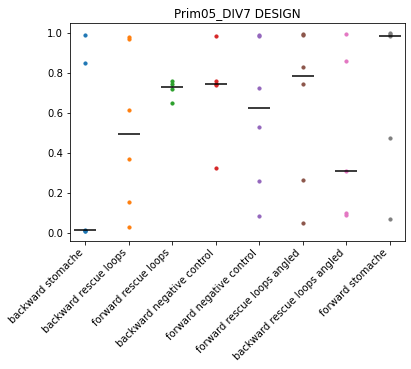

In [14]:
# =========== PRIM 05 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics.to_frame().unstack())

designs = all_metrics.index.unique('design')
print(designs)

# %matplotlib inline

plt.title(lbl+' DESIGN')
xlbls = []
for xloc, d in enumerate(designs):
    print(d)
    xlbls.append(design_namemap[prim][d])
    print(d, xloc, design_namemap[prim][d])
    
    design_metrics = all_metrics[d]
    # design_metrics[design_metrics>.9] = 1
    # design_metrics[design_metrics<.9] = 0
    # median = design_metrics.mean()

    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

plt.gca().set_xticks(np.arange(len(designs)))
plt.gca().set_xticklabels(xlbls, rotation=45, ha='right')

design  replicate
1       0                 NaN
        1            0.148972
        2            0.020968
        3            0.140803
        4            0.037754
                       ...   
8       3            0.292452
        4                 NaN
        5                 NaN
        6                 NaN
        7                 NaN
Name: diff_sumratio_intweighted, Length: 64, dtype: float64
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8


[Text(0, 0, 'negative control'),
 Text(1, 0, '3um opening'),
 Text(2, 0, '5um opening'),
 Text(3, 0, 'angled entry'),
 Text(4, 0, '1.5um opening'),
 Text(5, 0, 'inlay'),
 Text(6, 0, 'tangential entry'),
 Text(7, 0, '2x size')]

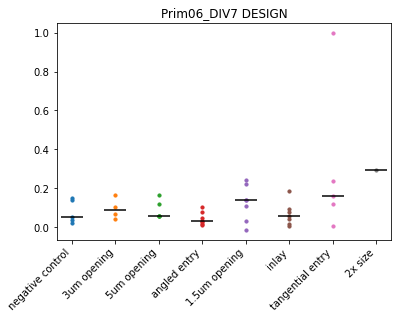

In [24]:

# =========== PRIM 6 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics)

designs = all_metrics.index.unique('design')
designs = range(1,9)

%matplotlib inline

plt.title(lbl+' DESIGN')
xlbls = []
for xloc, d in enumerate(designs):
    print(xloc, d)
    xlbls.append(design_namemap[prim][d])
    design_metrics = all_metrics[d]
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

plt.gca().set_xticks(np.arange(len(designs)))
plt.gca().set_xticklabels(xlbls, rotation=45, ha='right')

design  replicate
1       0                 NaN
        1            0.148972
        2            0.020968
        3            0.140803
        4            0.037754
                       ...   
8       3            0.292452
        4                 NaN
        5                 NaN
        6                 NaN
        7                 NaN
Name: diff_sumratio_intweighted, Length: 64, dtype: float64
5
4
5
7
7
7
5
1


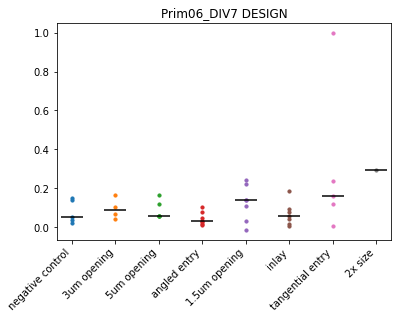

In [10]:

# =========== PRIM 6 ================

all_metrics = pd.read_csv(f'{dest_dir}/{lbl}_metrics.csv', index_col=(0,1)).iloc[:,0]
print(all_metrics)

designs = all_metrics.index.unique('design')
designs = range(1,9)

%matplotlib inline

plt.title(lbl+' DESIGN')
xlbls = []
for xloc, d in enumerate(designs):
    xlbls.append(design_namemap[prim][d])
    design_metrics = all_metrics[d]
    print(len(design_metrics.dropna()))
    median = design_metrics.median()
    xlocs = [xloc]*len(design_metrics)
    
    plt.scatter(xlocs, design_metrics, s=10)
    plt.scatter(xloc, median, marker='_', s=500, color='k')

plt.gca().set_xticks(np.arange(len(designs)))
plt.gca().set_xticklabels(xlbls, rotation=45, ha='right')
pass